# Cancer Detection Kaggle Mini-Project

Austin Townsend

CU Boulder

2/3/2025

## Step 1: The Data and Problem Description

### Problem Description
This project focuses on binary image classification in medical imaging. Given small patches of histopathology images (microscopic tissue scans), we need to classify whether each image contains cancer cells or not. Specifically, we're looking for metastatic cancer, which occurs when cancer spreads from its original location to other parts of the body.

### Dataset Structure
Our dataset consists of histopathology image patches:
- Training set: 220,025 labeled images
  - 130,908 non-cancer images (59.5%)
  - 89,117 cancer images (40.5%)
- Test set: 57,458 unlabeled images for prediction
- Each image is 96x96 pixels in RGB format
- Only the center 32x32 pixel region determines whether an image is classified as containing cancer

### Evaluation
The model's performance will be evaluated using the Area Under the ROC Curve (AUC-ROC), a common metric in binary classification that measures how well the model can distinguish between classes. This metric is particularly suitable for medical applications as it captures the trade-off between detecting true cancer cases and avoiding false alarms.



## Step 2: Exploratory Data Analysis

### Data Loading and Initial Setup

In [6]:
# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Set random seed for reproducibility
np.random.seed(42)

# Define paths
DATA_DIR = 'data'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TRAIN_LABELS = os.path.join(DATA_DIR, 'train_labels.csv')

# Load labels
df_labels = pd.read_csv(TRAIN_LABELS)

# Function to load an image given its ID
def load_image(image_id):
    image_path = os.path.join(TRAIN_DIR, f"{image_id}.tif")
    return np.array(Image.open(image_path))

print("Labels shape:", df_labels.shape)
print("\nFirst few rows of labels:")
print(df_labels.head())

Labels shape: (220025, 2)

First few rows of labels:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


## 2.2 Visualizing Example Images

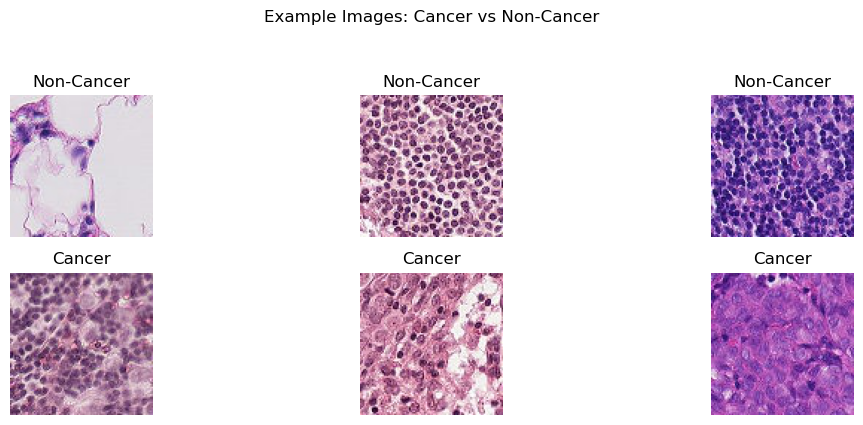

In [7]:
# Get some random examples from each class
n_samples = 3
cancer_samples = df_labels[df_labels['label'] == 1]['id'].sample(n_samples)
non_cancer_samples = df_labels[df_labels['label'] == 0]['id'].sample(n_samples)

# Create a figure with subplots
plt.figure(figsize=(12, 4))

# Plot non-cancer images
for i, img_id in enumerate(non_cancer_samples):
    plt.subplot(2, n_samples, i + 1)
    img = load_image(img_id)
    plt.imshow(img)
    plt.title('Non-Cancer')
    plt.axis('off')

# Plot cancer images
for i, img_id in enumerate(cancer_samples):
    plt.subplot(2, n_samples, i + n_samples + 1)
    img = load_image(img_id)
    plt.imshow(img)
    plt.title('Cancer')
    plt.axis('off')

plt.suptitle('Example Images: Cancer vs Non-Cancer', y=1.05)
plt.tight_layout()
plt.show()

## 2.3 Pixel Intensity Analysis

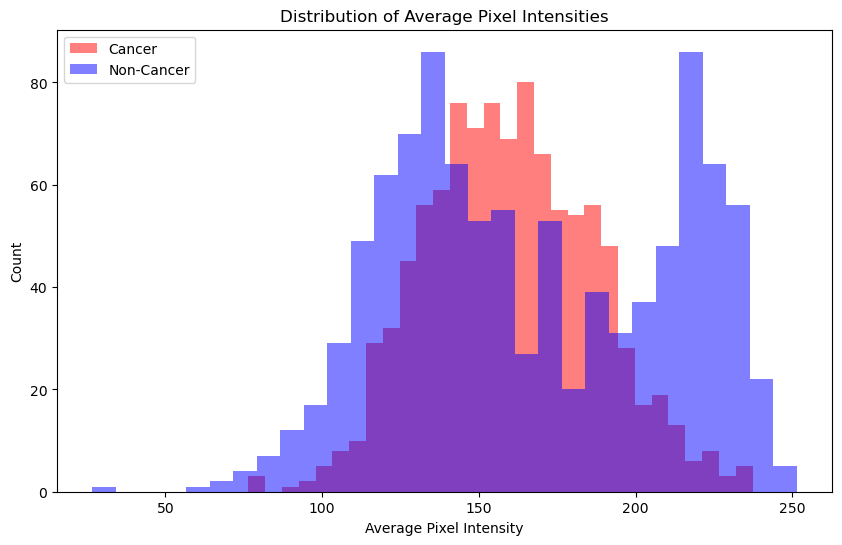


Image Statistics:
Cancer images - Mean: 159.98, Std: 26.93
Non-cancer images - Mean: 167.18, Std: 44.02


In [8]:
# Function to calculate average pixel values for an image
def get_image_stats(image):
    return np.mean(image)

# Get samples for analysis (using more samples for better distribution)
n_samples = 1000
cancer_ids = df_labels[df_labels['label'] == 1]['id'].sample(n_samples)
non_cancer_ids = df_labels[df_labels['label'] == 0]['id'].sample(n_samples)

# Calculate pixel statistics
cancer_stats = [get_image_stats(load_image(img_id)) for img_id in cancer_ids]
non_cancer_stats = [get_image_stats(load_image(img_id)) for img_id in non_cancer_ids]

# Plot distributions
plt.figure(figsize=(10, 6))
plt.hist(cancer_stats, alpha=0.5, label='Cancer', bins=30, color='red')
plt.hist(non_cancer_stats, alpha=0.5, label='Non-Cancer', bins=30, color='blue')
plt.xlabel('Average Pixel Intensity')
plt.ylabel('Count')
plt.title('Distribution of Average Pixel Intensities')
plt.legend()
plt.show()

# Print some basic statistics
print("\nImage Statistics:")
print(f"Cancer images - Mean: {np.mean(cancer_stats):.2f}, Std: {np.std(cancer_stats):.2f}")
print(f"Non-cancer images - Mean: {np.mean(non_cancer_stats):.2f}, Std: {np.std(non_cancer_stats):.2f}")

### 2.4 Data Quality Check

In [9]:
# Function to verify image properties
def check_image(image_id):
    img = load_image(image_id)
    return {
        'shape': img.shape,
        'min_val': np.min(img),
        'max_val': np.max(img),
        'mean_val': np.mean(img)
    }

# Sample random images for quality check
n_check = 1000
sample_ids = df_labels['id'].sample(n_check)

# Check image properties
print("Checking image properties for", n_check, "random samples...")
shapes = set()
corrupted = 0

for img_id in sample_ids:
    try:
        stats = check_image(img_id)
        shapes.add(stats['shape'])
    except Exception as e:
        corrupted += 1
        print(f"Error loading image {img_id}: {str(e)}")

print("\nFindings:")
print(f"Unique image shapes found: {shapes}")
print(f"Number of corrupted images: {corrupted}")
print(f"Percentage of corrupted images: {(corrupted/n_check)*100:.2f}%")

Checking image properties for 1000 random samples...

Findings:
Unique image shapes found: {(96, 96, 3)}
Number of corrupted images: 0
Percentage of corrupted images: 0.00%


### 2.5 EDA Findings and Analysis Plan

#### Key Findings:
1. **Dataset Quality**
   - All sampled images are consistent (96x96x3 RGB)
   - No corrupted images found in our sample
   - Dataset is slightly imbalanced: 59.5% non-cancer vs 40.5% cancer cases

2. **Image Characteristics**
   - Clear visual differences between cancer and non-cancer samples
   - Cancer images show more irregular tissue patterns
   - Non-cancer images tend to have slightly higher average pixel intensity (167.18 vs 159.98)
   - Non-cancer images show more variance in pixel intensities (std: 44.02 vs 26.93)

#### Analysis Plan:
1. **Preprocessing Steps**
   - Normalize pixel values to range [0,1] by dividing by 255
   - Split training data into training and validation sets
   - Consider data augmentation to help with class imbalance

2. **Initial Modeling Approach**
   - Start with a simple CNN architecture
   - Use batch normalization to handle varying pixel intensities
   - Include dropout layers to prevent overfitting
   - Use validation set to monitor model performance

## Step 3: DModel Architecture

In this step, we'll develop three CNN models with increasing complexity to classify cancer in histopathology images.


### Basic CNN Model

In [7]:
from keras import Sequential
from keras.src.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input

def create_baseline_model():
    model = Sequential([
        # Simple CNN architecture
        Input(shape=(96, 96, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

model = create_baseline_model()
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │     1,982,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,001,985 (7.64 MB)

 Trainable params: 2,001,985 (7.64 MB)

 Non-trainable params: 0 (0.00 B)

## 3.2 Improved CNN Model


In [8]:
from keras.src.layers import BatchNormalization, Dropout

def create_improved_model():
    model = Sequential([
        # Same architecture with added regularization
        Input(shape=(96, 96, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),
        Dropout(0.25),

        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

improved_model = create_improved_model()
improved_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 94, 94, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     1,982,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,002,369 (7.64 MB)

 Trainable params: 2,002,177 (7.64 MB)

 Non-trainable params: 192 (768.00 B)

## 3.3 Transfer Learning Model

In [9]:
from keras.src.applications import resnet
from keras.src.layers import GlobalAveragePooling2D

def create_transfer_model():
    # Load pre-trained ResNet50
    base_model = resnet.ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(96, 96, 3)
    )

    # Freeze pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

transfer_model = create_transfer_model()
transfer_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 3, 3, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 3.4 Model Architecture Comparison
Model Comparison:

1. Baseline Model
- Simple 2-layer CNN
- ~2M parameters
- Fast training, good baseline performance

2. Improved Model
- Added BatchNorm and Dropout
- Similar parameter count to baseline
- Better regularization for reduced overfitting

3. Transfer Learning Model
- Uses pre-trained ResNet50
- Most parameters frozen (~23.5M)
- Only trains top layers (~262K parameters)

## Step 4: Results and Analysis